<center> Python implementation of Kernel Current Source Density (kCSD) method - TUTORIAL </center>
======

In [1]:
%load_ext autoreload
%autoreload 2

from ipywidgets import interact
import numpy as np
import config

import plotting_helpers as plots
from widget_helpers import dim_select, csd_select, kcsd_select, accordion, nr_ele_select, nr_broken_ele, noise_select, regularization_select

In [2]:
# Select dimensions of your setup

dim_select

ToggleButtons(description='Dimensions of the setup:', options=('1D', '2D', '3D'), tooltips=['Laminar probes', 'MEA like flat electrodes', 'Utah array or SEEG'], value='1D')

In [3]:
# Select a type of CSD source

csd_select


ToggleButtons(description='True source type', options=('quadpole small', 'dipole large'), value='monopole gauss')

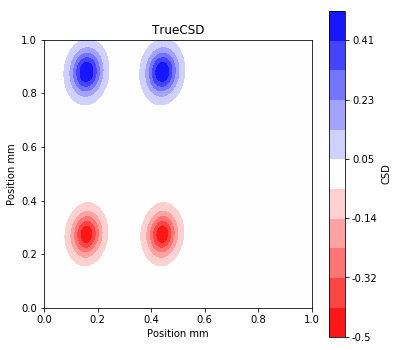

In [5]:
val = config.ValidateKCSD(dim=int(dim_select.value[0]))
csd_at, true_csd = val.generate_csd(config.csd_profile, csd_seed=5)
plots.show_csd(csd_at, true_csd)

In [6]:
# Select number of electrodes

nr_ele_select

BoundedIntText(value=10, description='Select nr of electrodes:', max=200, min=1)

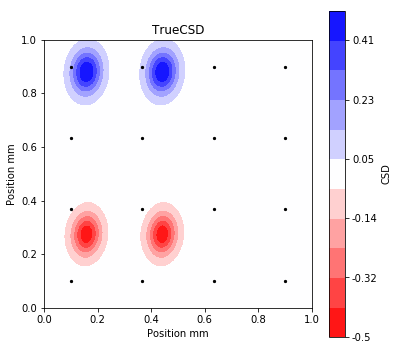

In [7]:
ele_pos = val.generate_electrodes(total_ele=nr_ele_select.value, ele_lims=[0.1, 0.9])
plots.show_csd(csd_at, true_csd, show_ele=ele_pos)

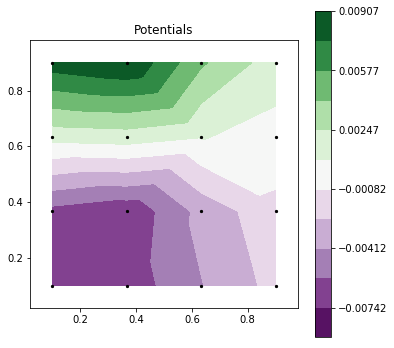

In [8]:
h = 0.25
sigma = 0.3
pots = val.calculate_potential(true_csd, csd_at, ele_pos, h, sigma)
plots.show_pot(ele_pos, pots)

In [9]:
# Do you want to investigate data with noise or without?

noise_select

FloatSlider(value=0.0, continuous_update=False, description='Noise level [%]:', readout_format='.1f')

In [16]:
if noise_select.value > 0:
    pots = val.add_noise(pots, level=noise_select.value)

In [9]:
kcsd_select

ToggleButtons(description='KCSD method', options=('ValidateKCSD2D', 'ValidateMoIKCSD'), value='ValidateKCSD1D')

In [12]:
print(kcsd_select.value)

ValidateMoIKCSD


In [13]:
# Call the main class with parameters of ground truth data and measurement setup

k = config.kCSD(csd_seed=5, **config.defaults[config.kCSD.__name__])

In [14]:
# Choose regularization method: cross-validation or L-curve

regularization_select

Select(description='Regularization method:', options=('cross-validation', 'L-curve'), value='cross-validation')

No lambda given, using defaults
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
R, lambda : 0.4 5.10896977451e-19


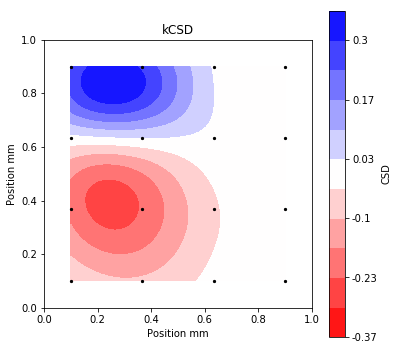

In [15]:
# Estimate current source density, change value of Rs to fit the best solution using crossvalidation

obj, est_csd = k.recon(pots, ele_pos, method=regularization_select.value, Rs=np.arange(0.2, 0.5, 0.1))
plots.show_csd(obj.estm_pos, est_csd, show_ele=ele_pos, show_kcsd=True)

In [16]:
# Investigate spectral structure of kCSD reconstruction

structure = config.SpectralStructure(obj)

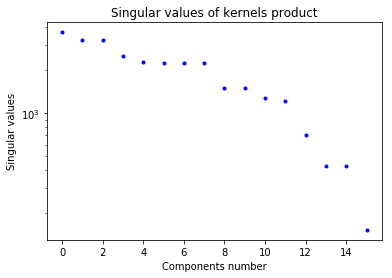

In [17]:
u_svd, sigma, v_svd = structure.svd()

Visibility maps
------

In [14]:
vmap = config.visibility_map(**config.defaults[config.kCSD.__name__])

#### Calculate errors for Visibility Map

It may take a few minutes.

In [15]:
# n - number of (pseudo) random sources included in calculation of error map 

rms, point_error = vmap.calculate_error_map(config.csd_profile, total_ele=nr_ele_select.value,
                                            n=100, Rs=np.arange(0.2, 0.5, 0.1), method=regularization_select.value)

Number of electrodes: 10
Number of electrodes: 10
Number of electrodes: 10
Number of electrodes: 10
Number of electrodes: 10
Number of electrodes: 10
Number of electrodes: 10
No lambda given, using defaults
min lambda 1e-07
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0156
max lambda 0.0156
No lambda given, using defaults
No lambda given, using defaults
min lambda 1e-07
min lambda 1e-07
max lambda 0.0156
max lambda 0.0156
No lambda given, using defaults
No lambda given, using defaults
min lambda 1e-07
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0156
max lambda 0.0156
min lambda 1e-07
max lambda 0.0156
min lambda 1e-07
min lambda 1e-07
max lambda 0.0157
max lambda 0.0157
l-curve (all lambda):  0.2
l-curve (all lambda):  0.2
min lambda 1e-07
max lambda 0.0157
l-curve (all lambda):  0.2
min lambda 1e-07
max lambda 0.0157
l-curve (all lambda):  0.2
min lambda 1e-07
max lambda 0.0157
l-curve (all lambda):  0.2
min lambda 1e-09
max lambda 0.0153
l-curve (al

min lambda 1e-09
max lambda 0.0153
max lambda 0.0153
l-curve (all lambda):  0.3
min lambda 1e-11
l-curve (all lambda):  0.3
min lambda 1e-11
max lambda 0.0147
max lambda 0.0147
min lambda 1e-09
l-curve (all lambda):  0.4
min lambda 1e-11
Best lambda and R =  3.56078132289e-08 ,  0.2
max lambda 0.0153
l-curve (all lambda):  0.4
max lambda 0.0147
Number of electrodes: 10
l-curve (all lambda):  0.3
l-curve (all lambda):  0.4
Best lambda and R =  3.56078132289e-08 ,  0.2
Number of electrodes: 10
Best lambda and R =  3.56078132289e-08 ,  0.2
Number of electrodes: 10
min lambda 1e-11
No lambda given, using defaults
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0147
min lambda 1e-07
max lambda 0.0156
l-curve (all lambda):  0.4
max lambda 0.0156
min lambda 1e-11
Best lambda and R =  8.7981630852e-08 ,  0.3
max lambda 0.0147
min lambda 1e-11
Number of electrodes: 10
l-curve (all lambda):  0.4
max lambda 0.0147
l-curve (all lambda):  0.4
min lambda 1e-07
max lambda 0.0157
l-curve

l-curve (all lambda):  0.2
max lambda 0.0157
Best lambda and R =  8.7981630852e-08 ,  0.3
l-curve (all lambda):  0.2
Number of electrodes: 10
min lambda 1e-11
max lambda 0.0147
min lambda 1e-07
max lambda 0.0157
l-curve (all lambda):  0.2
l-curve (all lambda):  0.4
Best lambda and R =  3.56078132289e-08 ,  0.2
min lambda 1e-09
max lambda 0.0153
min lambda 1e-07
max lambda 0.0157
Number of electrodes: 10
l-curve (all lambda):  0.2
l-curve (all lambda):  0.3
No lambda given, using defaults
min lambda 1e-07
min lambda 1e-09
max lambda 0.0156
max lambda 0.0153
l-curve (all lambda):  0.3
min lambda 1e-09
Best lambda and R =  3.56078132289e-08 ,  0.2
max lambda 0.0153
l-curve (all lambda):  0.3
Number of electrodes: 10
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0156
min lambda 1e-07
max lambda 0.0157
l-curve (all lambda):  0.2
min lambda 1e-09
max lambda 0.0153
l-curve (all lambda):  0.3
No lambda given, using defaults
min lambda 1e-11
min lambda 1e-07
max lambda 0.0147
l-

max lambda 0.0147
l-curve (all lambda):  0.4
l-curve (all lambda):  0.4
min lambda 1e-09
max lambda 0.0153
min lambda 1e-11
l-curve (all lambda):  0.3
Best lambda and R =  8.7981630852e-08 ,  0.3
Number of electrodes: 10
Best lambda and R =  3.56078132289e-08 ,  0.2
Number of electrodes: 10
max lambda 0.0147
l-curve (all lambda):  0.4
Best lambda and R =  3.56078132289e-08 ,  0.2
Number of electrodes: 10
Best lambda and R =  3.56078132289e-08 ,  0.2
Number of electrodes: 10
min lambda 1e-11
max lambda 0.0147
l-curve (all lambda):  0.4
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0156
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0156
Best lambda and R =  3.56078132289e-08 ,  0.2
Number of electrodes: 10
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0156
min lambda 1e-11
max lambda 0.0147
l-curve (all lambda):  0.4
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0156
Best lambda and R =  3.56078132289e-08 ,  0.2
min lambda 1

(80,)


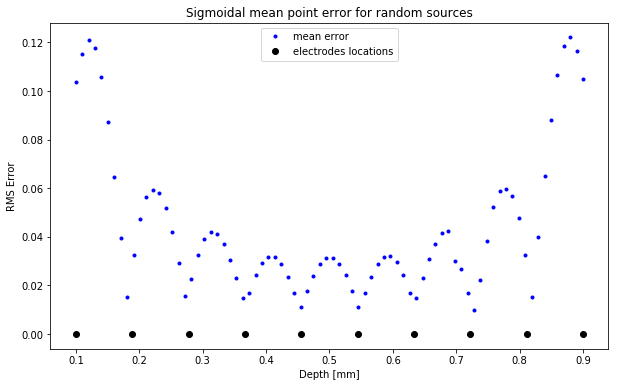

In [16]:
mask = vmap.plot_error_map(point_error, ele_pos)

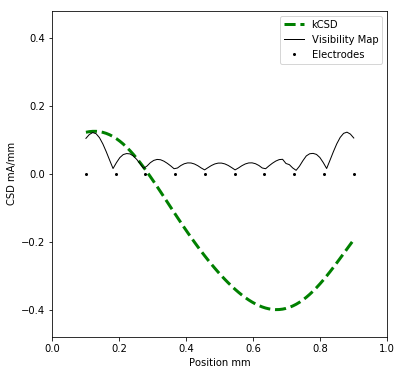

In [17]:
plots.show_csd(obj.estm_pos, est_csd, show_ele=ele_pos, show_kcsd=True, show_mask=mask)

In [18]:
# Choose how many electrodes are broken

nr_broken_ele

BoundedIntText(value=5, description='Select number of broken electrodes:', max=9, min=1)

In [19]:
ele_pos_br = vmap.generate_electrodes(total_ele=nr_ele_select.value, ele_lims=[0.1, 0.9],
                                      nr_broken_ele=nr_broken_ele.value)

In [20]:
rms_br, point_error_br = vmap.calculate_error_map(config.csd_profile, total_ele=nr_ele_select.value,
                                                  n=100, Rs=np.arange(0.2, 0.5, 0.1),
                                                  nr_broken_ele=nr_broken_ele.value, method=regularization_select.value)

Number of electrodes: 8
Number of electrodes: 8
Number of electrodes: 8
Number of electrodes: 8
Number of electrodes: 8
Number of electrodes: 8
Number of electrodes: 8
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0136
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0136
No lambda given, using defaults
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0136
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
min lambda 1e-07
min lambda 1e-07
min lambda 1e-07
min lambda 1e-07
max lambda 0.0136
max lambda 0.0136
max lambda 0.0136
max lambda 0.0136
min lambda 1e-06
max lambda 0.0137
l-curve (all lambda):  0.2
min lambda 1e-06
max lambda 0.0137
l-curve (all lambda):  0.2
min lambda 1e-06
max lambda 0.0137
l-curve (all lambda):  0.2
min lambda 1e-06
max lambda 0.0137
l-curve (all lambda):  0.2
min lambda 1e-06
min lambda 1e-06
max lambda 0.0137
max lambda 0.0137
l-curve (all lambda):  0.2
l-curve (all lambd

l-curve (all lambda):  0.3
min lambda 1e-09
max lambda 0.0128
l-curve (all lambda):  0.4
min lambda 1e-07
max lambda 0.0133
l-curve (all lambda):  0.3
Best lambda and R =  3.13482224276e-07 ,  0.2
min lambda 1e-07
Number of electrodes: 8
min lambda 1e-09
max lambda 0.0128
l-curve (all lambda):  0.4
max lambda 0.0133
l-curve (all lambda):  0.3
Best lambda and R =  3.13482224276e-07 ,  0.2
Number of electrodes: 8
min lambda 1e-09
max lambda 0.0128
l-curve (all lambda):  0.4
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0136
min lambda 1e-09
min lambda 1e-09
max lambda 0.0128
l-curve (all lambda):  0.4
Best lambda and R =  3.13482224276e-07 ,  0.2
max lambda 0.0128
l-curve (all lambda):  0.4
min lambda 1e-09
max lambda 0.0128
Number of electrodes: 8
l-curve (all lambda):  0.4
Best lambda and R =  3.13482224276e-07 ,  0.2
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0136
Number of electrodes: 8
Best lambda and R =  3.13482224276e-07 ,  0.2
min lambda 1e-06


Best lambda and R =  3.13482224276e-07 ,  0.2
max lambda 0.0137
min lambda 1e-06
max lambda 0.0137
l-curve (all lambda):  0.2
Number of electrodes: 8
min lambda 1e-09
max lambda 0.0128
l-curve (all lambda):  0.4
l-curve (all lambda):  0.2
min lambda 1e-06
max lambda 0.0137
l-curve (all lambda):  0.2
min lambda 1e-06
max lambda 0.0137
l-curve (all lambda):  0.2
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0136
min lambda 1e-07
max lambda 0.0133
l-curve (all lambda):  0.3
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0136
min lambda 1e-07
max lambda 0.0133
l-curve (all lambda):  0.3
Best lambda and R =  3.13482224276e-07 ,  0.2
Number of electrodes: 8
min lambda 1e-06
min lambda 1e-07
max lambda 0.0133
min lambda 1e-07
min lambda 1e-09
l-curve (all lambda):  0.3
max lambda 0.0137
max lambda 0.0128
l-curve (all lambda):  0.2
max lambda 0.0133
min lambda 1e-06
l-curve (all lambda):  0.3
l-curve (all lambda):  0.4
max lambda 0.0137
l-curve (all lambda):  0.2

l-curve (all lambda):  0.4
Best lambda and R =  3.13482224276e-07 ,  0.2
min lambda 1e-07
max lambda 0.0133
l-curve (all lambda):  0.3
Number of electrodes: 8
Best lambda and R =  3.13482224276e-07 ,  0.2
min lambda 1e-07
Number of electrodes: 8
max lambda 0.0133
min lambda 1e-09
l-curve (all lambda):  0.3
No lambda given, using defaults
max lambda 0.0128
min lambda 1e-07
l-curve (all lambda):  0.4
max lambda 0.0136
No lambda given, using defaults
min lambda 1e-07
max lambda 0.0136
Best lambda and R =  3.13482224276e-07 ,  0.2
Number of electrodes: 8
min lambda 1e-09
max lambda 0.0128
min lambda 1e-06
max lambda 0.0137
l-curve (all lambda):  0.2
l-curve (all lambda):  0.4
min lambda 1e-06
No lambda given, using defaults
max lambda 0.0137
Best lambda and R =  3.13482224276e-07 ,  0.2
l-curve (all lambda):  0.2
min lambda 1e-07
Number of electrodes: 8
max lambda 0.0136
min lambda 1e-09
max lambda 0.0128
min lambda 1e-07
l-curve (all lambda):  0.4
No lambda given, using defaults
max lambd

(80,)


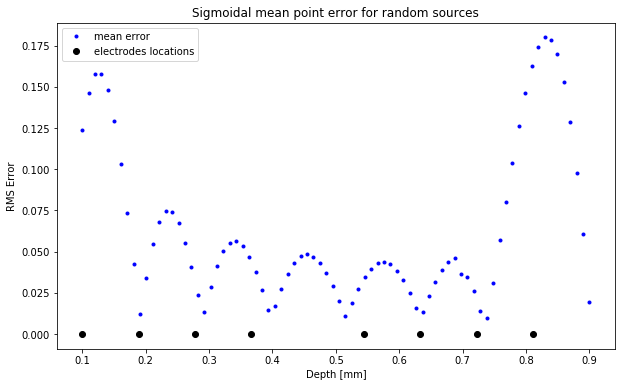

In [21]:
mask_br = vmap.plot_error_map(point_error_br, ele_pos_br)